In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy import linalg as LA
params ={'axes.labelsize' : 20,
         'axes.titlesize' : 20,
         'xtick.labelsize' : 15,
         'ytick.labelsize' : 15,}
plt.rcParams.update(params)

### Simulating experimental data

In [3]:
#function to generate a spectrum with some energy detuning:

def get_spectrum(E_detuning): #in keV
    #1. take sample spectrum
    #2. take detuned masked spectrum
    #3. convolute and get the image at the detector
    #4. GET A LIST of images with different detunings
    
    
    
    h = 4.135*10**(-6) #neV.s 
    #sample spectrum
    Gamma = 4.66 #neV
    N = 100 # number of points in a DFT
    w= np.linspace(-100,100,N) #in units of Gamma
    
    sample_w_0= 0 
    sample_fwhm_0= 20 #neV

    sample_amp = 1/(1+4*(w-sample_w_0)**2/sample_fwhm_0**2) #normalised
    sample_phase = math.pi/(1+np.exp(-2*(w-sample_w_0)))


    #mask spectrum
    mask_w_0= 0 #(keV)
    mask_fwhm_0= 20 #neV
    mask_amp = 1/(1+4*(w-(mask_w_0+E_detuning))**2/mask_fwhm_0**2)
    mask_phase = math.pi/(1+np.exp(-2*(w-(mask_w_0+E_detuning))))

    sample_data = sample_amp*np.exp(1j*sample_phase)
    mask_data   = mask_amp*np.exp(1j*mask_phase)
    exp_data= sample_data*mask_data
    detector_img= np.fft.ifft(exp_data)

    time_data = np.linspace(0,10**9 *h/(Gamma*abs(w[1]-w[0])), len(exp_data)) # the plot of frequencies
    
    return w, time_data, np.abs(detector_img)**2 , mask_data, sample_data

In [4]:
#simulate experimental data
img_data=[]
detuned_mask_data =[]

for E_detuning in np.linspace(-50,50,20): #detuning unit in gamma, 50 copies of detuned measurements
    w, time_data, ydata, mask_data, sample_data = get_spectrum(E_detuning)
    #ydata[45:]=0
    img_data.append(ydata)
    detuned_mask_data.append(mask_data)
    


In [5]:
measured_data_list=np.stack(img_data, axis=0) #50 Real measured Intensity spectra
mask_data_list = np.stack(detuned_mask_data, axis=0) #50 Complex Mask spectra

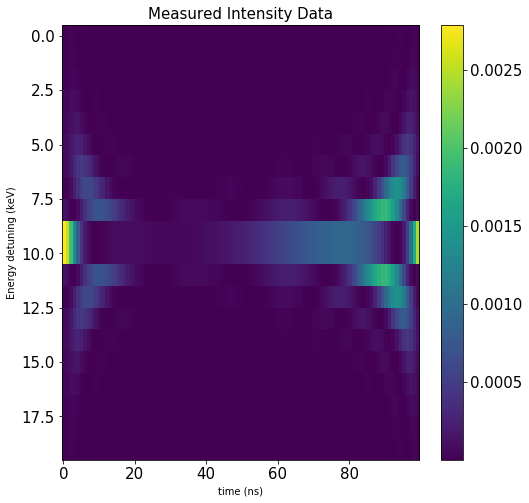

In [6]:
plt.figure(figsize=(8,8))
plt.title('Measured Intensity Data', fontsize=15)
plt.imshow(measured_data_list,interpolation='nearest',aspect='auto')
plt.xlabel('time (ns)', fontsize=10)
plt.ylabel('Energy detuning (keV)', fontsize=10)
plt.colorbar()
plt.show()

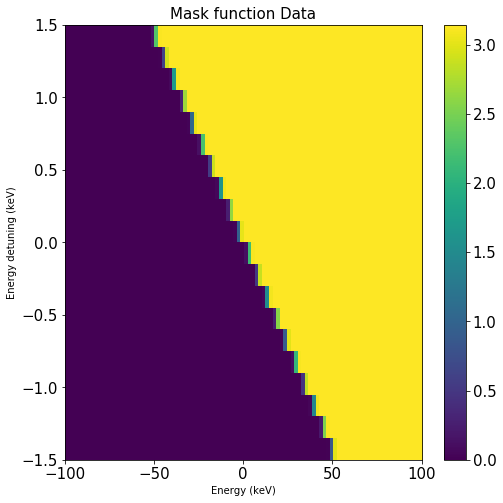

In [7]:
plt.figure(figsize=(8,8))
plt.xlabel('Energy (keV)', fontsize=10)
plt.ylabel('Energy detuning (keV)', fontsize=10)
plt.title('Mask function Data', fontsize=15)
plt.imshow(np.angle(mask_data_list),interpolation='nearest',aspect='auto', extent = [w[0] , w[-1], -1.5 , 1.5])
plt.colorbar()
plt.show()

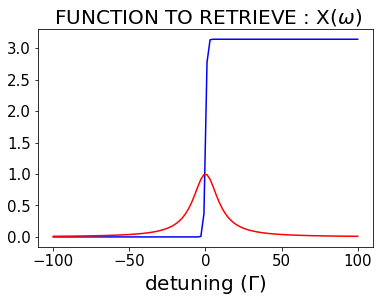

In [8]:
plt.figure(figsize=(8,8))
fig,ax= plt.subplots()
ax.plot(w, np.angle(sample_data), color = "blue")
ax.plot(w, np.abs(sample_data), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = " FUNCTION TO RETRIEVE : X($\omega$)")
plt.show()

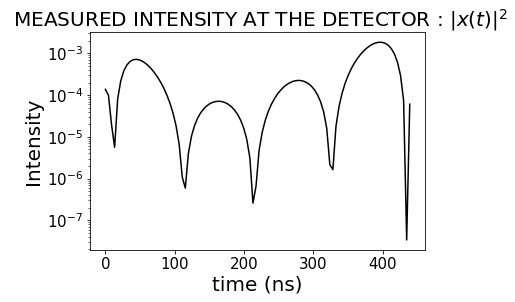

In [9]:
fig,ax= plt.subplots()

ax.semilogy(time_data,measured_data_list[11], color = "black")
#ax.plot(w, exp_phase)
#ax.set_xlim([0,800])
ax.set(xlabel = "time (ns)",
       ylabel = "Intensity",
       title = " MEASURED INTENSITY AT THE DETECTOR : $|x(t)|^2$")
#ax.xaxis.label.set_size(20)
#ax.yaxis.label.set_size(20)

plt.show()

## cut off part of the measured graph

In [10]:
#measured_data_list[:,np.where(time_data >200)] = 0


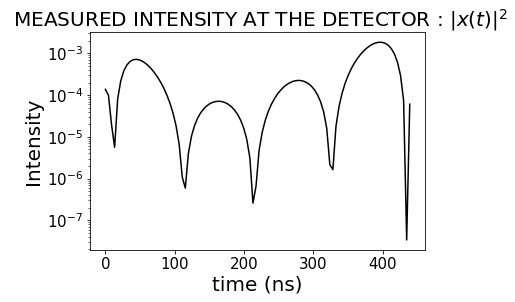

In [11]:
fig,ax= plt.subplots()

ax.semilogy(time_data,measured_data_list[11], color = "black")
#ax.plot(w, exp_phase)
#ax.set_xlim([0,800])
ax.set(xlabel = "time (ns)",
       ylabel = "Intensity",
       title = " MEASURED INTENSITY AT THE DETECTOR : $|x(t)|^2$")
#ax.xaxis.label.set_size(20)
#ax.yaxis.label.set_size(20)

plt.show()

## Standard PIE ALGORITHM

In [15]:
def HannosMethod(mask_data_list, measured_data_list, obj_0, alpha, beta, max_iter):
    
    obj_n = obj_0
    z_c = np.zeros_like(obj_0)
    
    for n in range(0,max_iter):
        
        L= len(mask_data_list)
        
        
        for i in range(L): #iterates over all different probe positions i

            #for the i-th copy of the measured signal

            a = mask_data_list[i] #probe function
            a_star = np.conj(a) #probe* function
            psi_guess= a*obj_n #exit wave
            z= np.fft.ifft(psi_guess) # exit wave in time plane
            #z_c[:180]= z[:180]
            
            b = np.sqrt(measured_data_list[i]) #b_i = sqrt(I_i) real measured amplitude of the convoluted signal
            #b = b/LA.norm(b) #normalise b
            z_c =b*np.exp(1j*np.angle(z)) # z_c(t) corrected conv signal guess in t domain
            psi_corrected =  np.fft.fft(z_c) #corrected exit wave
            
            #object update
            #obj_n = obj_n+ beta* abs(a)/max(abs(a)) *  abs(a)/(abs(a)**2 + alpha)*(psi_corrected-psi_guess)
            obj_n = obj_n+ alpha* 1/( (abs(a))**2 +0.000000001) *(a_star)*(psi_corrected-psi_guess)
            #obj_n = obj_n+ alpha* 1/( max(abs(a))**2 +0.000000001) *(a_star)*(psi_corrected-psi_guess)
            
            #loop break condition 
            # autocorrelation between the different obj copies?
        
        
        
    #print('Exceeded maximum iterations. No solution found.')
            
    return obj_n

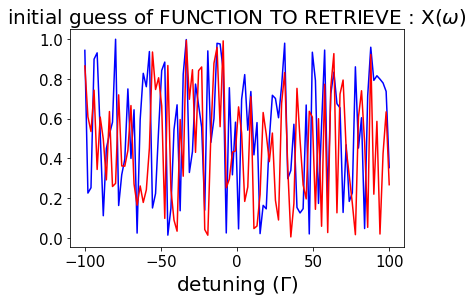

In [16]:

obj_0 = np.random.random(len(mask_data_list[0]))*np.exp(1j*np.random.random(len(mask_data_list[0])))
plt.figure(figsize=(8,8))
fig,ax= plt.subplots()
ax.plot(w, np.angle(obj_0), color = "blue")
ax.plot(w, np.abs(obj_0), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = "initial guess of FUNCTION TO RETRIEVE : X($\omega$)")
plt.show()

In [34]:
#apply the steepest descent algorithm

# choice of 0<beta<1


alpha, beta,max_iter=0.,0.1,3
approx_obj = HannosMethod(mask_data_list, measured_data_list, obj_0, alpha, beta, max_iter)
#print(approx_obj) #give the x for which p(x)=0

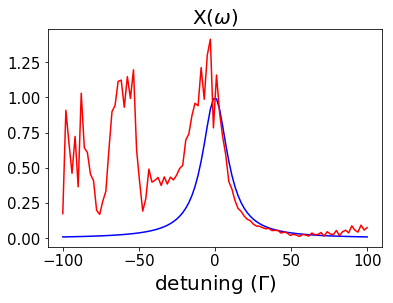

In [35]:
fig,ax= plt.subplots()
plt.figure(figsize=(25,25))
ax.plot(w, np.abs(sample_data), color = "blue")
ax.plot(w, np.abs(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = "X($\omega$)")
plt.show()

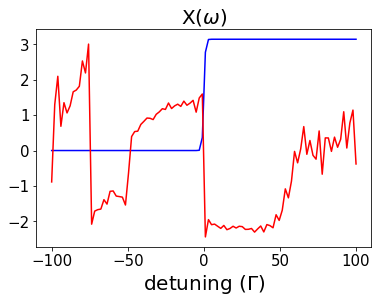

In [36]:
fig,ax= plt.subplots()
plt.figure(figsize=(25,25))
ax.plot(w, np.angle(sample_data), color = "blue")
ax.plot(w, np.angle(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = "X($\omega$)")
plt.show()

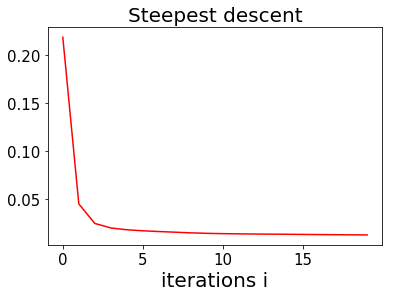

In [251]:
fig,ax= plt.subplots()
#ax.plot(w, np.angle(Drho_n),color ="blue")
ax.plot( rho[0: 20], color ="red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "iterations i",
       ylabel = "",
       title = "Steepest descent")
plt.show()